# Fruit & Vegetables Freshness Classification

## Import Libraries

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Download Dataset from Google Drive

In [2]:
pip install gdown

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for gdown: filename=gdown-4.4.0-py3-none-any.whl size=14759 sha256=1553708eab642af819586e69da53038b29a80351674ff3757ecdc0916173c210
  Stored in directory: /root/.cache/pip/wheels/fb/c3/0e/c4d8ff8bfcb0461afff199471449f642179b74968c15b7a69c
Successfully built gdown
Note: you may need to restart the kernel to use updated packages.


In [3]:
!gdown --id 1ftK3lZTKsKTXFivFHJfjpPzYiXDvNID2

/opt/conda/lib/python3.7/site-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1ftK3lZTKsKTXFivFHJfjpPzYiXDvNID2
To: /kaggle/working/fruitveg.zip
100%|██████████████████████████████████████| 1.05G/1.05G [01:17<00:00, 13.6MB/s]


In [4]:
import os
import zipfile 

data_dir = './fruitveg'
os.mkdir(data_dir)

with zipfile.ZipFile('fruitveg.zip', 'r') as zip_file:
    zip_file.extractall(data_dir)

## <span style='background :LemonChiffon' > Prepare dataset </span>

### Set parameters and load dataset

In [5]:
from tensorflow.keras.utils import image_dataset_from_directory

batch_size = 32
img_height = 224
img_width = 224
img_size = (img_height, img_width)
img_shape = img_size + (3,)

# Edit according to local path for dataset
ds_path = r"fruitveg"

train_ds = image_dataset_from_directory(ds_path,
                                        validation_split = 0.2,
                                        subset = "training",
                                        seed = 123,
                                        image_size = img_size,
                                        batch_size = batch_size)

val_ds = image_dataset_from_directory(ds_path,
                                      validation_split = 0.2,
                                      subset = "validation",
                                      seed = 123,
                                      image_size = img_size,
                                      batch_size = batch_size)

Found 4178 files belonging to 18 classes.
Using 3343 files for training.


2022-05-30 13:53:55.553047: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-30 13:53:55.652765: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-30 13:53:55.653535: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-30 13:53:55.655777: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Found 4178 files belonging to 18 classes.
Using 835 files for validation.


In [6]:
class_names = train_ds.class_names
num_classes = len(class_names)

print(class_names)

['f_apple', 'f_banana', 'f_carrot', 'f_greens', 'f_orange', 'f_tomato', 'm_apple', 'm_banana', 'm_carrot', 'm_greens', 'm_orange', 'm_tomato', 'r_apple', 'r_banana', 'r_carrot', 'r_greens', 'r_orange', 'r_tomato']


### Sample images

2022-05-30 13:54:08.598290: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


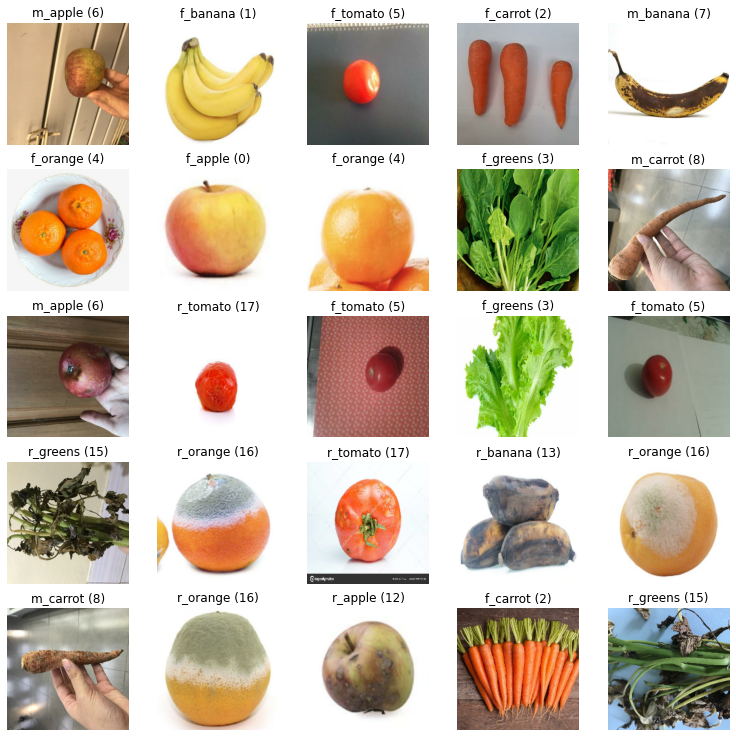

In [7]:
plt.figure(figsize=(13, 13))
for images, labels in train_ds.take(1):
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]] + ' ({})'.format(labels[i]))
        plt.axis("off")

### Create test set

In [8]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_dataset = val_ds.take(val_batches // 2)
validation_dataset = val_ds.skip(val_batches // 2)

In [9]:
# Buffered prefetching
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_ds.prefetch(buffer_size = AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size = AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size = AUTOTUNE)

## <span style='background :LemonChiffon' > Building the model </span>

### Using transfer learning
Run one of the three following cells to choose from the ResNet50, MobileNetV2, and InceptionV3 pre-trained models. 

* ResNet50

In [10]:
# Create ResNet50 base model
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions

pre_trained_model = ResNet50(input_shape = img_shape,
                        include_top = False,
                        weights = 'imagenet')

# pre_trained_model.trainable = False

94781440/94765736 [==============================] - 0s 0us/step


* MobileNetV2

In [ ]:
# Create MobileNetV2 base model 
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input

pre_trained_model = MobileNetV2(input_shape = img_shape,
                        include_top = False,
                        weights = 'imagenet')

# pre_trained_model.trainable = False

* InceptionV3

In [ ]:
# Create InceptionV3 base model
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input

pre_trained_model = InceptionV3(input_shape = img_shape,
                        include_top = False,
                        weights = 'imagenet')

# pre_trained_model.trainable = False

In [ ]:
# Base model architecture
pre_trained_model.summary()

### Fine tuning layers

In [11]:
print("Number of layers: ", len(pre_trained_model.layers))

Number of layers:  175


In [12]:
pre_trained_model.trainable = True

# Fine-tune from this layer onwards
START_TRAIN = 170

# Freeze all the layers before 
for layer in pre_trained_model.layers[:START_TRAIN]:
    layer.trainable = False

### Preprocess input and add classification layer

In [13]:
# Averaging layer
global_average = tf.keras.layers.GlobalAveragePooling2D()

# Data augmentation 
augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal_and_vertical'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomTranslation(height_factor = (-0.2, 0.2),
                                      width_factor = (-0.2, 0.2),
                                      fill_mode="nearest",
                                      interpolation="bilinear"),
    tf.keras.layers.RandomContrast(0.2)  
])

# Add dense layer
prediction_layer = tf.keras.layers.Dense(num_classes, activation='softmax')

# Chain model 
inputs = tf.keras.Input(shape = img_shape)
x = augmentation(inputs) 
x = preprocess_input(x)
x = pre_trained_model(x, training=False)
x = global_average(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs,outputs)

### Compile model

In [14]:
# Compile model
LR = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = LR),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
              metrics=['accuracy'])

# Display model architecture
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 224, 224, 3)       0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0     

### Building model from scratch
Run the following cell to build model from scratch, for transfer learning run the above cells.

In [ ]:
# Preprocessing
data_augmentation = tf.keras.Sequential([ 
    tf.keras.layers.RandomFlip('horizontal_and_vertical'),
    tf.keras.layers.RandomRotation(0.2)
])
    
rescale = tf.keras.layers.Rescaling(1./255) 
    
# Convolutional neural network
cnn = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(128, (3,3), activation='relu', input_shape=img_shape),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

# Chain model
inputs = tf.keras.Input(shape = img_shape)
x = data_augmentation(inputs) 
x = rescale(x)
outputs = cnn(x)
model = tf.keras.Model(inputs,outputs)
    
# Compile model
lr = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = lr),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
              metrics=['accuracy'])

# Display model architecture
model.summary()

## <span style='background :LemonChiffon' > Model training </span>

In [15]:
# Callback function
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.98):
            print("\nReached 98% accuracy so cancelling training!")
            self.model.stop_training = True
            
callbacks = myCallback()

In [16]:
EPOCH = 100

history = model.fit(
            train_dataset,
            validation_data = validation_dataset,
            epochs = EPOCH,
            callbacks=[callbacks])

Epoch 1/100


2022-05-30 13:57:35.336718: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


105/105 [==============================] - 60s 453ms/step - loss: 2.1086 - accuracy: 0.3760 - val_loss: 0.8181 - val_accuracy: 0.7566
Epoch 2/100
105/105 [==============================] - 49s 441ms/step - loss: 0.9678 - accuracy: 0.6799 - val_loss: 0.5815 - val_accuracy: 0.8091
Epoch 3/100
105/105 [==============================] - 50s 447ms/step - loss: 0.7216 - accuracy: 0.7568 - val_loss: 0.4649 - val_accuracy: 0.8449
Epoch 4/100
105/105 [==============================] - 47s 418ms/step - loss: 0.5994 - accuracy: 0.7978 - val_loss: 0.4094 - val_accuracy: 0.8735
Epoch 5/100
105/105 [==============================] - 46s 415ms/step - loss: 0.5360 - accuracy: 0.8098 - val_loss: 0.4318 - val_accuracy: 0.8759
Epoch 6/100
105/105 [==============================] - 47s 418ms/step - loss: 0.4693 - accuracy: 0.8394 - val_loss: 0.3564 - val_accuracy: 0.8831
Epoch 7/100
105/105 [==============================] - 47s 416ms/step - loss: 0.4323 - accuracy: 0.8480 - val_loss: 0.3621 - val_accurac

### Training Evaluation

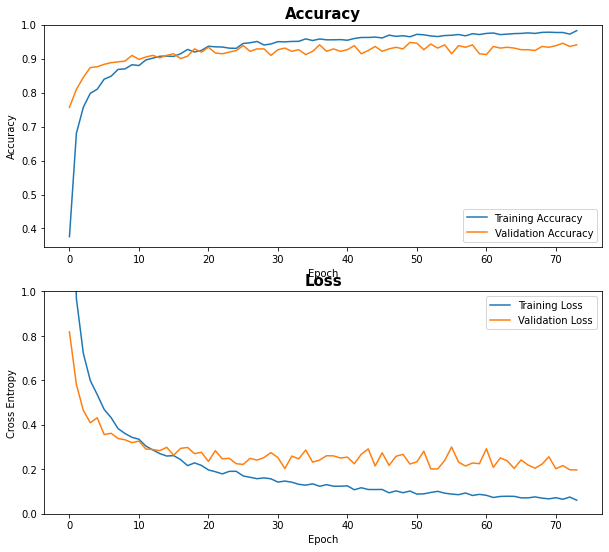

In [17]:
plt.figure(figsize=(10, 9))

# training and validation accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim([min(plt.ylim()),1])
plt.title('Accuracy', size=15, fontweight='bold')

# training and validation loss
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.xlabel('Epoch')
plt.ylim([0,1.0])
plt.title('Loss', size=15, fontweight='bold')
plt.show()

## <span style='background :LemonChiffon' > Predicting images </span>

In [18]:
# Upload image to be predicted
from ipywidgets import FileUpload

upload = FileUpload()
upload

FileUpload(value={}, description='Upload')

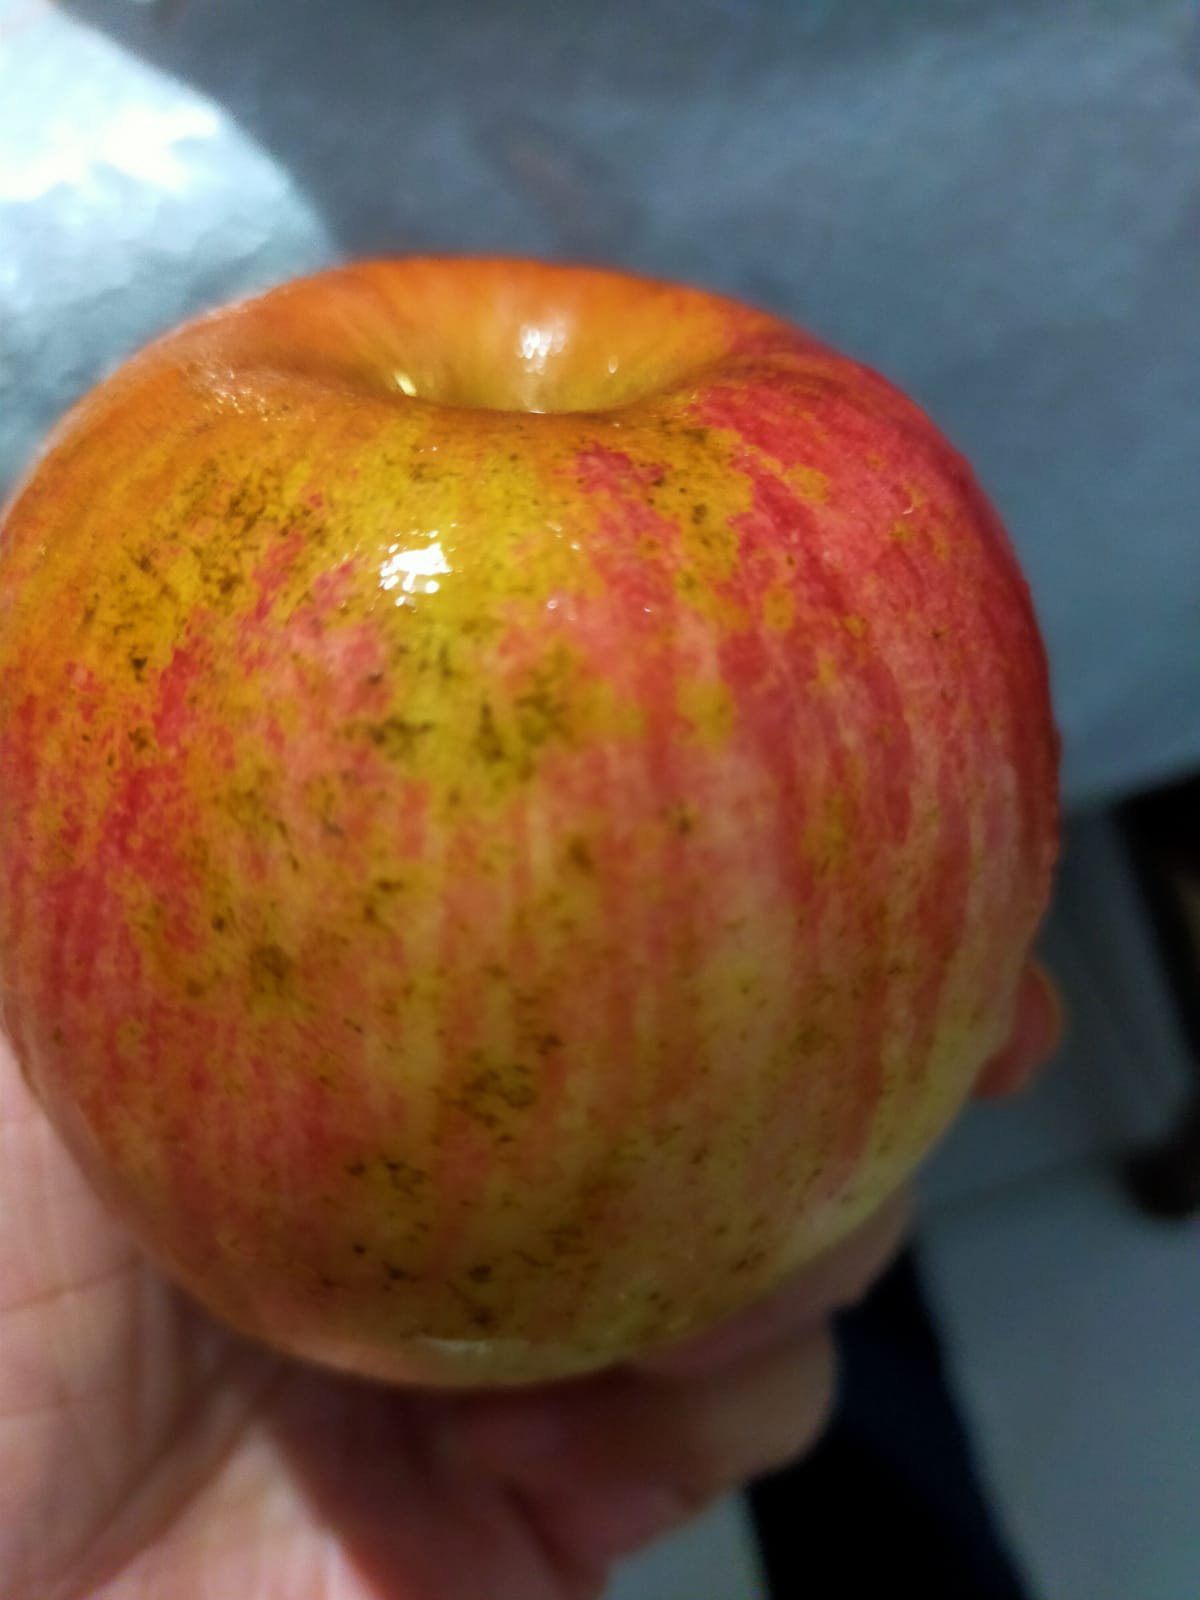

In [29]:
# Display image
import io
from PIL import Image

for name, file_info in upload.value.items():
    pic = Image.open(io.BytesIO(file_info['content']))

pic

In [30]:
# Resize image
x = np.array(pic)
x = tf.image.resize(x, [img_height, img_width])
x = np.expand_dims(x, axis=0)

# Predict image class
pred_img = model.predict(x)
pred_idx = np.argmax(pred_img, axis=-1)

print("It's a {}!".format(class_names[int(pred_idx)]))
print(pred_idx)
print(pred_img)

It's a m_apple!
[6]
[[3.8749336e-03 2.7060914e-06 4.2110200e-06 1.2505127e-06 2.8594100e-06
  4.6642876e-06 9.8863262e-01 1.3904672e-05 4.2598036e-05 2.3313066e-06
  5.6939395e-03 4.6923378e-04 9.4380113e-04 1.7175654e-06 3.4153098e-05
  1.2323981e-05 1.2925804e-04 1.3350364e-04]]


### Confusion Matrix

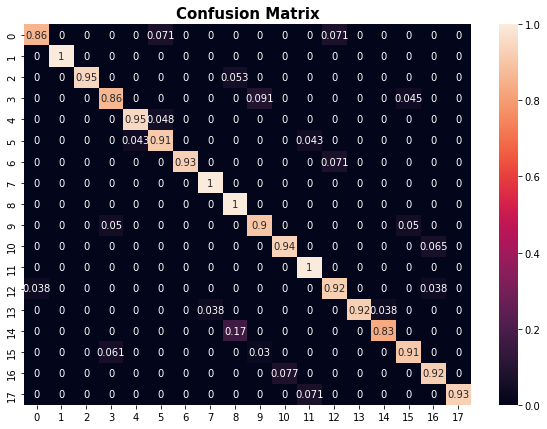

In [31]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

predicted = []  # predicted labels
true = []  # true labels

for image_batch, label_batch in test_dataset:  
    true.append(label_batch)
    prediction = model.predict(image_batch)
    predicted.append(np.argmax(prediction, axis=-1))

# convert labels into tensors
true_labels = tf.concat([item for item in true], axis=0)
predicted_labels = tf.concat([item for item in predicted], axis=0)

cf_matrix = confusion_matrix(true_labels, predicted_labels, normalize='true')

# plot confusion  matrix
plt.figure(figsize = (10,7))
sns.heatmap(cf_matrix, 
            annot=True)
plt.title('Confusion Matrix', size=15, fontweight='bold')
plt.show()

## <span style='background :LemonChiffon' > Save model </span>

In [32]:
model.save('fruitveg_updated.h5')

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [33]:
tf.saved_model.save(model, 'fruitveg_updated')

2022-05-30 15:31:19.097120: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
